# PoroTomo DAS Data Processing Tutorial for hdf5 Files via HSDS and h5pyd

Prior to running this script, make sure the following are installed within your Python environment:
 - boto3
 - numpy
 - matplotlib
 - h5pyd
 - sys
 - os
    
After installation, run the following:

In [1]:
import boto3, os, logging
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

import sys
import os

import h5pyd

boto3.set_stream_logger('boto3', logging.INFO)
s3 = boto3.resource('s3')
bucket = s3.Bucket('nrel-pds-porotomo')
cwd = os.getcwd()

## NREL Highly Scalable Data Service (HSDS)

This service operates with the HSDS software developed by the [HDF Group](https://www.hdfgroup.org/) and is hosted on Amazon Web Services (AWS) using a combination of EC2 (Elastic Compute) and S3 (Scalable Storage Service). You can read more about the HSDS service [in this slide deck](https://www.slideshare.net/HDFEOS/hdf-cloud-services).

## How to Use

Install the h5pyd library:

```
pip install h5pyd
```

Next you'll need to configure HSDS:

```
hsconfigure
```

and enter at the prompt:

```
hs_endpoint = https://developer.nrel.gov/api/hsds
hs_username = None
hs_password = None
hs_api_key = 3K3JQbjZmWctY0xmIfSYvYgtIcM3CN0cb1Y2w9bf
```

*The example API key here is for demonstation and is rate-limited per IP. To get your own API key, visit https://developer.nrel.gov/signup/*

You can also add the above contents to a configuration file at ~/.hscfg

The files available via HSDS are stored by day. Here, we'll access a smsall portion of the file from March 15. The file number specified below represents the number of the first 30 second hdf5 file imported above using h5py that includes the mystery event. The 30 second files are not available via HSDS, but are available here: https://s3.console.aws.amazon.com/s3/buckets/nrel-pds-porotomo/H5/DASH/20160315/?region=us-west-2&tab=overview. The length of the file specified below represents the length of one of these files.


In [2]:
file_num = 123+900  # file number
file_len = 30000    # file length
event_loc = file_num*file_len

In [3]:
path = '/nrel/porotomo/DASH/PoroTomo_iDAS16043_20160315.h5'

Below, we read in a portion of the March 15 file using h5pyd and HSDS.

In [4]:
data_stream = []
with h5pyd.File(path, 'r') as f:
    for i in np.arange(2):
        event_loc = event_loc+file_len*i
        das = np.array(f['das'][event_loc:event_loc+file_len])
        data_stream.append(das)
        print(list(f))

['channel', 'crs', 'das', 't', 'trace', 'x', 'y', 'z']
['channel', 'crs', 'das', 't', 'trace', 'x', 'y', 'z']


## Plotting Raw Data
### Plotting Individual Traces
Individual traces within a stream can be accessed by accessing individual columns of the numpy arrays. In this code block, a subset of the traces are placed into an array and plotted to show change in amplitude over time at different positions along the cable.

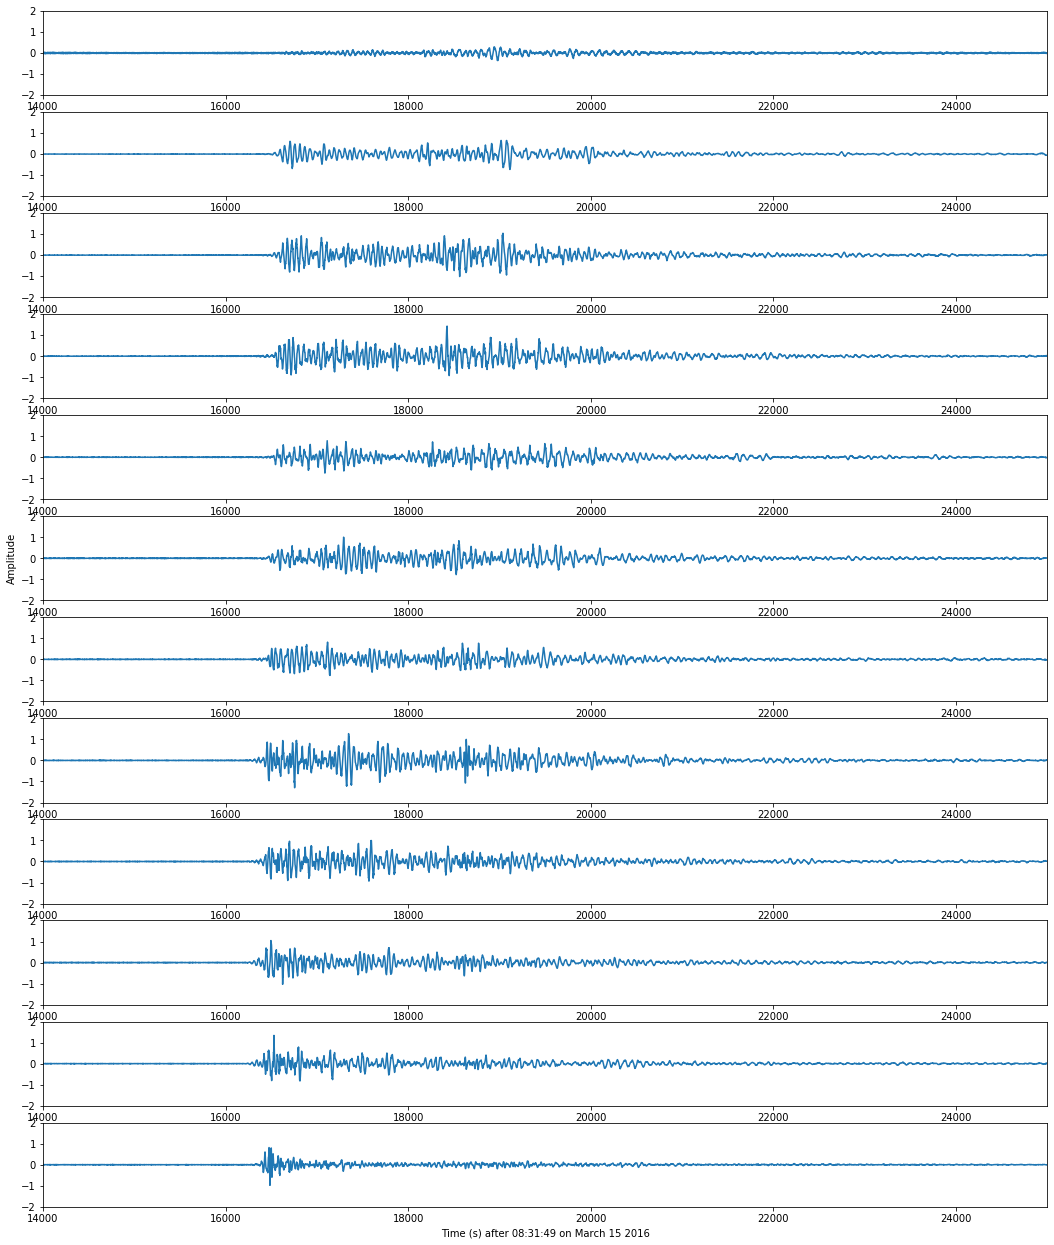

In [5]:
traces = []; trace_no=0
start_trace=40; trace_inc = 15; num_traces = 12
ylim = [-2,2]; xlim=[14000,25000]
data = data_stream[0]

for index in np.arange(num_traces):
    traces.append(data[:,start_trace+trace_inc*index])
    
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12) = plt.subplots(12,figsize=(18,22))
ax1.plot(traces[trace_no].data); ax1.set_ylim(ylim); ax1.set_xlim(xlim); trace_no+=1
ax2.plot(traces[trace_no].data); ax2.set_ylim(ylim); ax2.set_xlim(xlim); trace_no+=1
ax3.plot(traces[trace_no].data); ax3.set_ylim(ylim); ax3.set_xlim(xlim); trace_no+=1
ax4.plot(traces[trace_no].data); ax4.set_ylim(ylim); ax4.set_xlim(xlim); trace_no+=1
ax5.plot(traces[trace_no].data); ax5.set_ylim(ylim); ax5.set_xlim(xlim); trace_no+=1
ax6.plot(traces[trace_no].data); ax6.set_ylim(ylim); ax6.set_xlim(xlim); trace_no+=1
ax6.set_ylabel('Amplitude')
ax7.plot(traces[trace_no].data); ax7.set_ylim(ylim); ax7.set_xlim(xlim); trace_no+=1
ax8.plot(traces[trace_no].data); ax8.set_ylim(ylim); ax8.set_xlim(xlim); trace_no+=1
ax9.plot(traces[trace_no].data); ax9.set_ylim(ylim); ax9.set_xlim(xlim); trace_no+=1
ax10.plot(traces[trace_no].data); ax10.set_ylim(ylim); ax10.set_xlim(xlim); trace_no+=1
ax11.plot(traces[trace_no].data); ax11.set_ylim(ylim); ax11.set_xlim(xlim); trace_no+=1
ax12.plot(traces[trace_no].data); ax12.set_ylim(ylim); ax12.set_xlim(xlim); trace_no+=1
ax12.set_xlabel('Time (s) after 08:31:49 on March 15 2016')
plt.show()
    

### Size of Data

In [6]:
raw_data = data_stream
size = sys.getsizeof(raw_data[0])+sys.getsizeof(raw_data[1])
print("size of two raw datasets: {:.4f} GB".format(size*10**-9))

raw_data = []
raw_data.append(data_stream[0].T)
raw_data.append(data_stream[1].T)


size of two raw datasets: 2.0930 GB


### Determining Upper and Lower Limits of the Data
In order to determine upper and lower bounds for the colorbar, the 99th percentile, maximum value, and standard deviation are calculated. 

In [7]:
vm0 = np.percentile(raw_data[0], 99)
std0 = np.std(raw_data[0])
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is  {:.4f}".format(vm0, raw_data[0].max(),std0))


The 99th percentile is 0.0397; the max amplitude is 2.4027; the standard deviation is  0.0292


In [8]:
vm1 = np.percentile(raw_data[1], 99)
std1 = np.std(raw_data[1])
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is  {:.4f}".format(vm1, raw_data[1].max(),std1))


The 99th percentile is 0.0134; the max amplitude is 2.0574; the standard deviation is  0.0193


### Plotting all Traces as an Image Using imshow

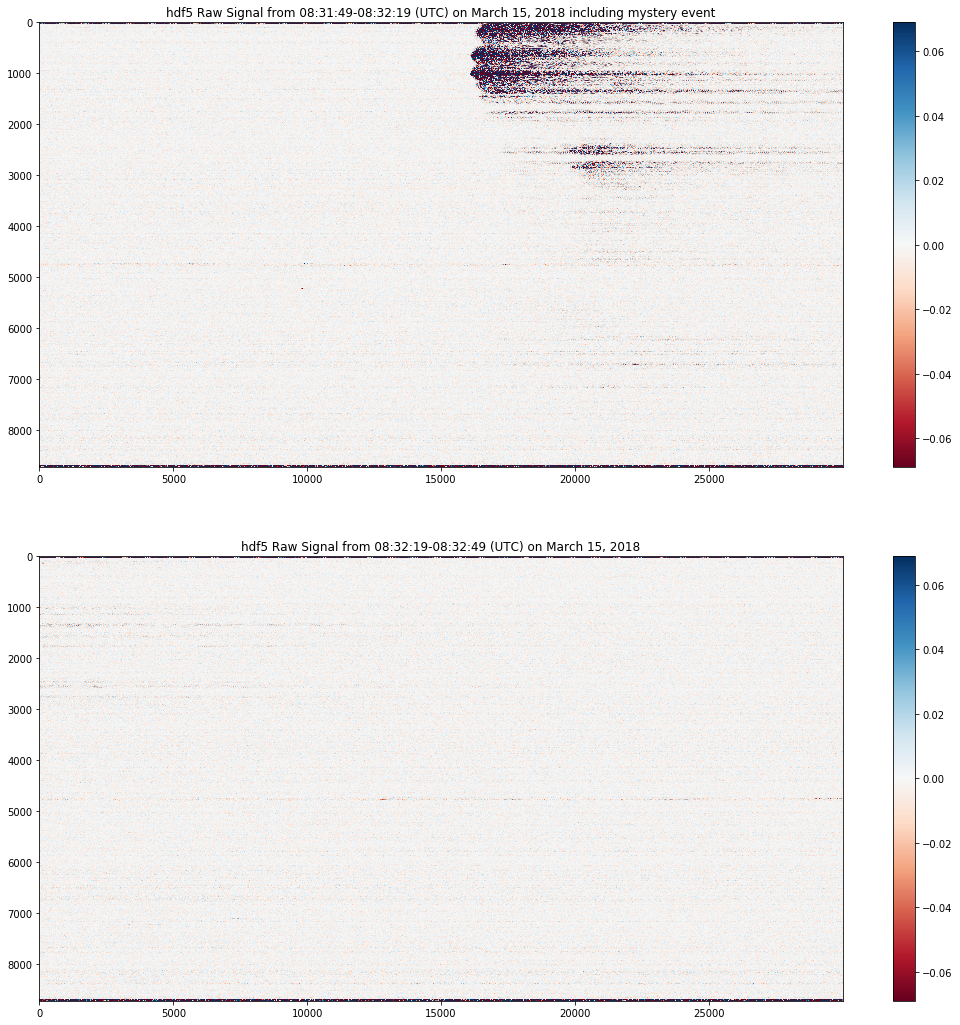

In [9]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(18,18))
mystery_event = ax1.imshow(raw_data[0], cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.colorbar(mystery_event,ax=ax1)
ax1.set_title('hdf5 Raw Signal from 08:31:49-08:32:19 (UTC) on March 15, 2018 including mystery event')

noise = ax2.imshow(raw_data[1], cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.colorbar(noise,ax=ax2)
ax2.set_title('hdf5 Raw Signal from 08:32:19-08:32:49 (UTC) on March 15, 2018')

plt.show()

### Isolating the Mystery Event

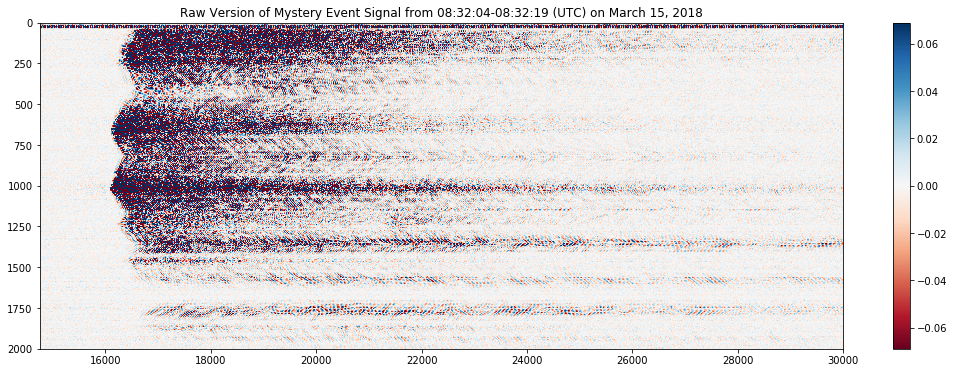

In [10]:
plt.figure(figsize=(18,6))
mystery_event = plt.imshow(raw_data[0], cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.xlim(14750,30000)
plt.ylim(2000,0)

plt.colorbar(mystery_event)
plt.title('Raw Version of Mystery Event Signal from 08:32:04-08:32:19 (UTC) on March 15, 2018')
plt.show()

## Filtering
Scipy.signal's butter function offers the following filter types:
 - bandpass
 - bandstop
 - lowpass
 - highpass
 
Here we will apply the low pass butterworth filter to only the mystery event data array.
 
### Applying Low Pass Filter

In [11]:
lowpass_filter = signal.butter(2,Wn=0.001,btype='low',output='sos')
filt_data = signal.sosfilt(lowpass_filter, raw_data[0])

### Plotting Filtered Data

In [12]:
traces = []; trace_no=0
start_trace=40; trace_inc = 15; num_traces = 12
ylim = [-.02,.02]; xlim=[14000,25000]
data = filt_data.T

for index in np.arange(num_traces):
    traces.append(data[:,start_trace+trace_inc*index])

fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12) = plt.subplots(12,figsize=(18,22))
ax1.plot(traces[trace_no].data); ax1.set_ylim(ylim); ax1.set_xlim(xlim); trace_no+=1
ax2.plot(traces[trace_no].data); ax2.set_ylim(ylim); ax2.set_xlim(xlim); trace_no+=1
ax3.plot(traces[trace_no].data); ax3.set_ylim(ylim); ax3.set_xlim(xlim); trace_no+=1
ax4.plot(traces[trace_no].data); ax4.set_ylim(ylim); ax4.set_xlim(xlim); trace_no+=1
ax5.plot(traces[trace_no].data); ax5.set_ylim(ylim); ax5.set_xlim(xlim); trace_no+=1
ax6.plot(traces[trace_no].data); ax6.set_ylim(ylim); ax6.set_xlim(xlim); trace_no+=1
ax6.set_ylabel('Amplitude')
ax7.plot(traces[trace_no].data); ax7.set_ylim(ylim); ax7.set_xlim(xlim); trace_no+=1
ax8.plot(traces[trace_no].data); ax8.set_ylim(ylim); ax8.set_xlim(xlim); trace_no+=1
ax9.plot(traces[trace_no].data); ax9.set_ylim(ylim); ax9.set_xlim(xlim); trace_no+=1
ax10.plot(traces[trace_no].data); ax10.set_ylim(ylim); ax10.set_xlim(xlim); trace_no+=1
ax11.plot(traces[trace_no].data); ax11.set_ylim(ylim); ax11.set_xlim(xlim); trace_no+=1
ax12.plot(traces[trace_no].data); ax12.set_ylim(ylim); ax12.set_xlim(xlim); trace_no+=1
ax12.set_xlabel('Time (s) after 08:31:49 on March 15 2016')
plt.show()

In [13]:
vm_filt = np.percentile(filt_data, 99)
std_filt = np.std(filt_data)
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is  {:.4f}".format(vm_filt, filt_data.max(),std_filt))


The 99th percentile is 0.0001; the max amplitude is 0.0864; the standard deviation is  0.0010


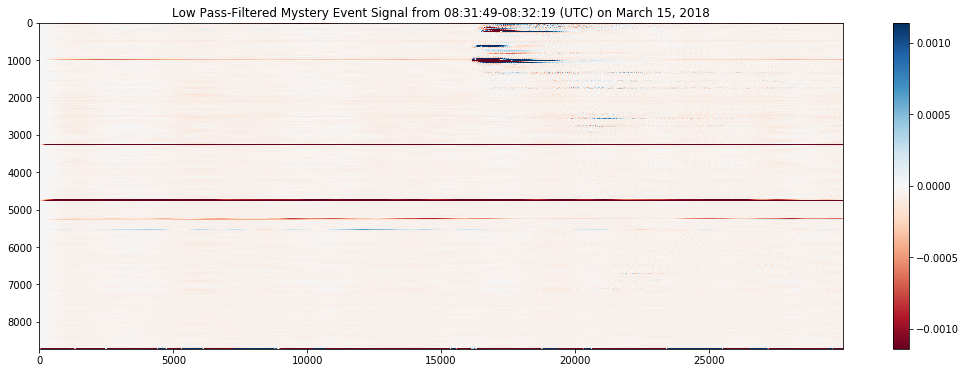

In [14]:
plt.figure(figsize=(18,6))
mystery_event = plt.imshow(filt_data, cmap="RdBu", vmin=-vm_filt-std_filt, vmax=vm_filt+std_filt, aspect='auto')
plt.colorbar()
plt.title('Low Pass-Filtered Mystery Event Signal from 08:31:49-08:32:19 (UTC) on March 15, 2018')
plt.show()


In [15]:
plt.figure(figsize=(18,6))
myster_event = plt.imshow(filt_data, cmap="RdBu", vmin=-vm_filt+std_filt, vmax=vm_filt-std_filt, aspect='auto')
plt.xlim(14000,25000)
plt.ylim(2000,0)

plt.colorbar()
plt.title('Low Pass-Filtered Mystery Event Signal from 08:32:04-08:32:19 (UTC) on March 15, 2018')
plt.show()


## Resampling the Data
Scipy.signal's resample function offers downsampling by specifying the desired number of samples in the resampled signal. Here, we want to downsample by a factor of 100, so our target number of samples is 300.

In [16]:
sampling_rate_stream = 1000
sampling_rate = sampling_rate_stream/100 # in Hz or samples per s
num_samples=int(30000/100)
resamp_data = filt_data.copy().T
resamp_data=signal.resample(resamp_data,num_samples)

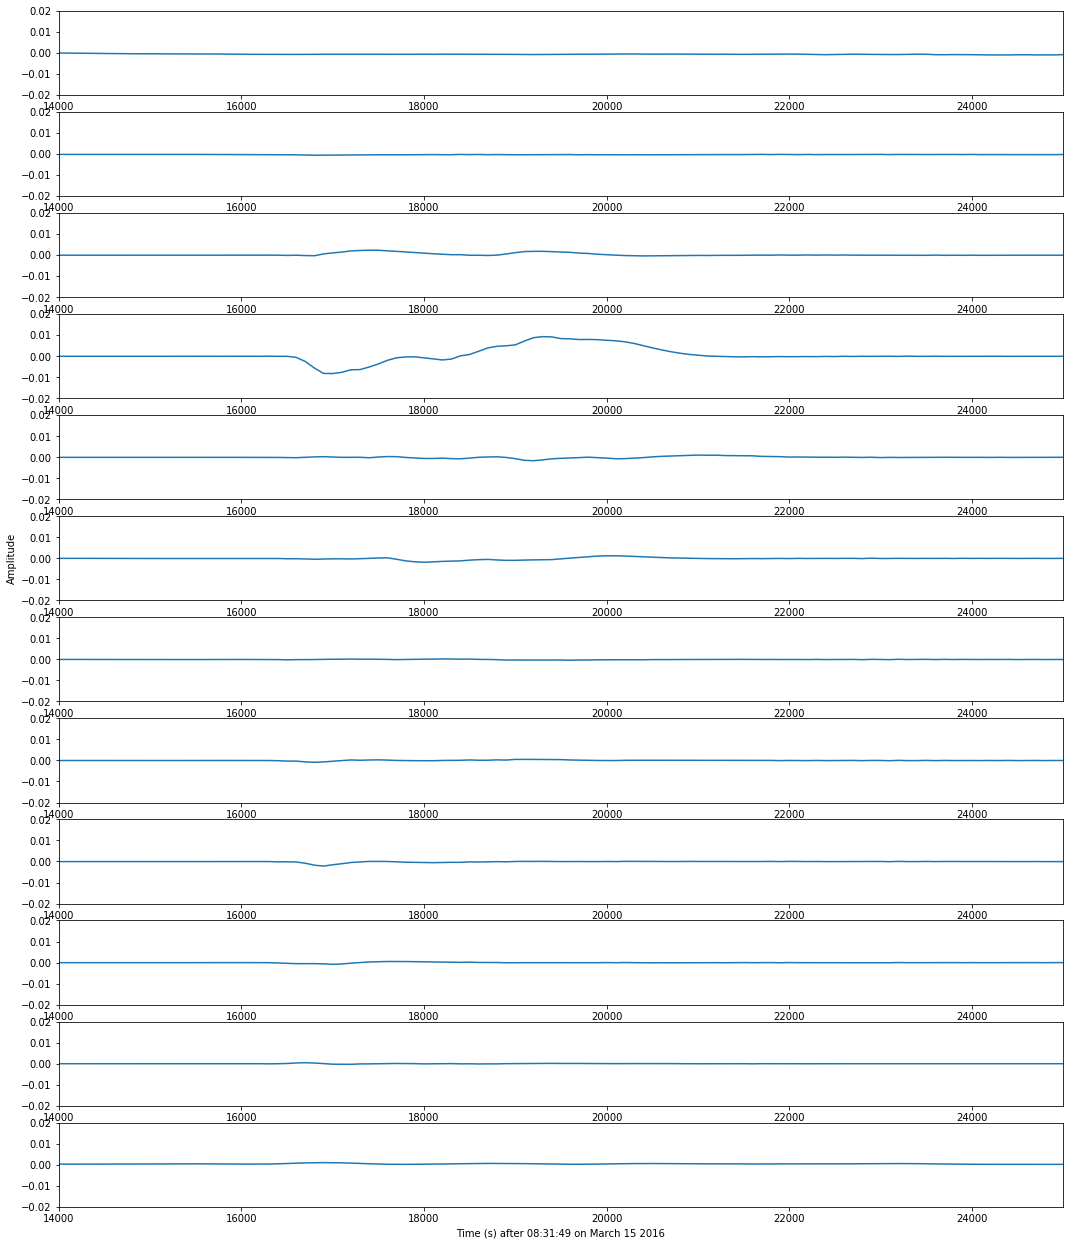

In [17]:
traces = []; trace_no=0
start_trace=40; trace_inc = 15; num_traces = 12
ylim = [-.02,.02]; xlim=[14000,25000]
data = resamp_data

for index in np.arange(num_traces):
    traces.append(data[:,start_trace+trace_inc*index])

ylim = [-.02,.02]; xlim=[14000/(sampling_rate_stream/sampling_rate),25000/(sampling_rate_stream/sampling_rate)]

fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12) = plt.subplots(12,figsize=(18,22))
ax1.plot(traces[trace_no].data); ax1.set_ylim(ylim); ax1.set_xlim(xlim); trace_no+=1
ax1.set_xticklabels(np.arange(14000,25000,2000))
ax2.plot(traces[trace_no].data); ax2.set_ylim(ylim); ax2.set_xlim(xlim); trace_no+=1
ax2.set_xticklabels(np.arange(14000,25000,2000))
ax3.plot(traces[trace_no].data); ax3.set_ylim(ylim); ax3.set_xlim(xlim); trace_no+=1
ax3.set_xticklabels(np.arange(14000,25000,2000))
ax4.plot(traces[trace_no].data); ax4.set_ylim(ylim); ax4.set_xlim(xlim); trace_no+=1
ax4.set_xticklabels(np.arange(14000,25000,2000))
ax5.plot(traces[trace_no].data); ax5.set_ylim(ylim); ax5.set_xlim(xlim); trace_no+=1
ax5.set_xticklabels(np.arange(14000,25000,2000))
ax6.plot(traces[trace_no].data); ax6.set_ylim(ylim); ax6.set_xlim(xlim); trace_no+=1
ax6.set_xticklabels(np.arange(14000,25000,2000))
ax6.set_ylabel('Amplitude')
ax7.plot(traces[trace_no].data); ax7.set_ylim(ylim); ax7.set_xlim(xlim); trace_no+=1
ax7.set_xticklabels(np.arange(14000,25000,2000))
ax8.plot(traces[trace_no].data); ax8.set_ylim(ylim); ax8.set_xlim(xlim); trace_no+=1
ax8.set_xticklabels(np.arange(14000,25000,2000))
ax9.plot(traces[trace_no].data); ax9.set_ylim(ylim); ax9.set_xlim(xlim); trace_no+=1
ax9.set_xticklabels(np.arange(14000,25000,2000))
ax10.plot(traces[trace_no].data); ax10.set_ylim(ylim); ax10.set_xlim(xlim); trace_no+=1
ax10.set_xticklabels(np.arange(14000,25000,2000))
ax11.plot(traces[trace_no].data); ax11.set_ylim(ylim); ax11.set_xlim(xlim); trace_no+=1
ax11.set_xticklabels(np.arange(14000,25000,2000))
ax12.plot(traces[trace_no].data); ax12.set_ylim(ylim); ax12.set_xlim(xlim); trace_no+=1
ax12.set_xticklabels(np.arange(14000,25000,2000))
ax12.set_xlabel('Time (s) after 08:31:49 on March 15 2016')
plt.show()

In [18]:
size = sys.getsizeof(resamp_data)
print("{:.4f} GB".format(size * 10**-9))

0.0209 GB


In [19]:
resamp_data = resamp_data.T

In [20]:
vm_resamp = np.percentile(resamp_data, 99)
std_resamp = np.std(resamp_data)
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is {:.4f}".format(vm_resamp, resamp_data.max(),std_resamp))


The 99th percentile is 0.0001; the max amplitude is 0.0859; the standard deviation is 0.0010


In [21]:
fig, ax = plt.subplots(figsize=(18,6))
mystery_event = plt.imshow(resamp_data, cmap="RdBu", vmin=-vm_resamp-std_resamp, vmax=vm_resamp+std_resamp, aspect='auto')
ax.set_xticklabels(np.arange(-5000,30000,5000))
plt.colorbar()
plt.title('Low Pass-Filtered and Resampled Mystery Event Signal from 08:31:49-08:32:19 (UTC) on March 15, 2018')
plt.show()


In [22]:
fig, ax = plt.subplots(figsize=(18,6))
mystery_event = plt.imshow(resamp_data, cmap="RdBu", vmin=-vm_resamp-std_resamp, vmax=vm_resamp+std_resamp, aspect='auto')
plt.xlim(14000/(sampling_rate_stream/sampling_rate),25000/(sampling_rate_stream/sampling_rate))
plt.ylim(2000,0)
ax.set_xticklabels(np.arange(14000,30000,2000))
plt.colorbar(mystery_event)
plt.title('Low Pass-Filtered and Resampled Mystery Event Signal from 08:32:04-08:32:19 (UTC) on March 15, 2018')
plt.show()

## Comparison of the three Mystery Event Images

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(18,18))
mystery_event = ax1.imshow(raw_data[0], cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.colorbar(mystery_event,ax=ax1)
ax1.set_title('Raw Signal from 08:31:49-08:32:19 (UTC) on March 15, 2018 including mystery event')
ax1.set_xlim(14000,25000)
ax1.set_ylim(1500,0)

filt = ax2.imshow(filt_data, cmap="RdBu", vmin=-vm_filt-std_filt, vmax=vm_filt+std_filt, aspect='auto')
plt.colorbar(filt,ax=ax2)
ax2.set_title('Low Pass-Filtered Mystery Event Signal from 08:32:04-08:32:19 (UTC) on March 15, 2018')
ax2.set_xlim(14000,25000)
ax2.set_ylim(1500,0)

resamp = ax3.imshow(resamp_data, cmap="RdBu", vmin=-vm_filt-std_filt, vmax=vm_filt+std_filt, aspect='auto')
plt.colorbar(resamp,ax=ax3)
ax3.set_title('Low Pass-Filtered and Resampled Mystery Event Signal from 08:32:04-08:32:19 (UTC) on March 15, 2018')
ax3.set_xlim(14000/(sampling_rate_stream/sampling_rate),25000/(sampling_rate_stream/sampling_rate))
ax3.set_ylim(1500,0)
ax3.set_xticklabels(np.arange(14000,30000,2000))
plt.show()